In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext autotime

import pandas as pd
import io
import boto3
from boto3.dynamodb.conditions import Key
import os
import PIL
import json
import numpy as np
import pathlib
import pickle
import dask

from sklearn.model_selection import train_test_split

import textacy
import en_core_web_sm

import seaborn as sns

# from custo import greedy_algorithm
#import input_data_preprocessing.corpus_stats as c_stats

textacy.spacier.doc_extensions.set_doc_extensions()
en = en_core_web_sm.load()
#import code
print(textacy.__version__)
os.getcwd()


/home/ec2-user/anaconda3/envs/py36-ml/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


0.8.0


'/home/ec2-user/environment/pytig'

### Load TIG Data

In [2]:
%time
import pytig as ptg

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
time: 273 ms


### Inputs

In [3]:

data_dir_name = 'data'

metadata_folder_name = 'photosynthesis_raw'
txt_dir_flname =  "text"
img_dir_flname =  'images'

    
zip_url = f"https://github.com/gryBox/pytig-data/raw/master/{metadata_folder_name}.zip"
data_dir_flpth = os.path.abspath(data_dir_name)
print(data_dir_flpth)

metadata_flpth = os.path.join(data_dir_flpth, metadata_folder_name)
print(metadata_flpth)

text_data_flpth = os.path.join(metadata_flpth, txt_dir_flname)
image_data_flpth = os.path.join(metadata_flpth, img_dir_flname)

/home/ec2-user/environment/pytig/data
/home/ec2-user/environment/pytig/data/photosynthesis_raw
time: 1.89 ms


## Load Data

In [4]:
# Load Data
# 1. Load training data for algorithm (Needs to be done even if only using predict)
zipfile = ptg.write.zip_to_metadata_dir(zip_url, data_dir_name)

DEBUG:root:None


File Name                                             Modified             Size
photosynthesis_raw/                            2019-06-16 18:07:00            0
photosynthesis_raw/images/                     2019-06-16 18:07:00            0
photosynthesis_raw/images/photosynthesis_1.jpg 2019-06-16 18:07:00        30607
photosynthesis_raw/images/photosynthesis_2.jpg 2019-06-16 18:07:00        15706
photosynthesis_raw/images/photosynthesis_4.jpg 2019-06-16 18:07:00        39833
photosynthesis_raw/images/photosynthesis_3.jpg 2019-06-16 18:07:00        18635
photosynthesis_raw/images/photosynthesis_0.jpg 2019-06-16 18:07:00         6911
photosynthesis_raw/images/photosynthesis_5.jpg 2019-06-16 18:07:00        35177
photosynthesis_raw/images/photosynthesis_6.jpg 2019-06-16 18:07:00        35177
photosynthesis_raw/text/                       2019-06-16 18:07:00            0
photosynthesis_raw/text/photosynthesis_4.txt   2019-06-16 18:07:00         1162
photosynthesis_raw/text/photosynthesis_0

## Prepare Metadata Folder for AttnGAN
- Normalize Filenames
- Create basename file
- Pickle Files
- Sample caption files

### Prepare Filenames

In [5]:
# Prepare MetaData folder for attngan model


# 1.  Prepare Filenames
# a. Extract basenames
prpFilenames = ptg.filenames.PrepareFilenames(metadata_flpth, 
                                                   image_data_flpth, 
                                                   text_data_flpth, 
                                                   )
# b. Write new filenames back to disk using the new filenames and updates the fileNames_df 
prpFilenames.rename_filenames()
    
# c. Write basenames to a ".txt" file in the metadata folder
prpFilenames.basenames_to_txtfile(basename_flname='filenames.txt')

INFO:root:filenames_to_df -- Loading Filenames from dict_keys(['text', 'images']) 
INFO:root:Finished writing new image and text filenames to disk
DEBUG:root:Finished writing filenames to: /home/ec2-user/environment/pytig/data/photosynthesis_raw/filenames.txt Number of Basenames: (7,)


time: 37 ms


In [6]:
prpFilenames.fileNames_df

text  \
0  /home/ec2-user/environment/pytig/data/photosyn...   
1  /home/ec2-user/environment/pytig/data/photosyn...   
2  /home/ec2-user/environment/pytig/data/photosyn...   
3  /home/ec2-user/environment/pytig/data/photosyn...   
4  /home/ec2-user/environment/pytig/data/photosyn...   
5  /home/ec2-user/environment/pytig/data/photosyn...   
6  /home/ec2-user/environment/pytig/data/photosyn...   

                                              images          basename  
0  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_0  
1  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_1  
2  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_2  
3  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_3  
4  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_4  
5  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_5  
6  /home/ec2-user/environment/pytig/data/photosyn...  photosynthesis_6

time: 9.6 ms


### Split Data

In [7]:
metaFolder = ptg.prepare_metadata_dir.Metadata(metadata_flpth, image_data_flpth, text_data_flpth)

time: 878 µs


In [8]:
train_filenames, test_filenames = metaFolder.split_data(prpFilenames.fileNames_df, 
                                                        test_size=0.3,  
                                                        filenames_clm=prpFilenames.basenameCol)

INFO:root:Number of training data files: {train_filenames.shape}
INFO:root:Number of test data files: {test_filenames.shape}
INFO:root:Writing pickle file to /home/ec2-user/environment/pytig/data/photosynthesis_raw/train/filenames.pickle
DEBUG:root:Writing pickle file of file type: <class 'list'>
INFO:root:Writing pickle file to /home/ec2-user/environment/pytig/data/photosynthesis_raw/test/filenames.pickle
DEBUG:root:Writing pickle file of file type: <class 'list'>


time: 10.5 ms


### Analyze Captions

In [9]:
# Standard imports 

from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

time: 162 ms


#### photosynthesis

In [10]:
# 1. Load text captions to corpus
captCrps = ptg.write.txt_to_corpus(text_data_flpth, lang=en, txt_extention=".txt")
print(f"\nCorpus Info: {captCrps}")

# 2. Preview some docs
example_doc = 5
cap_doc = captCrps[example_doc]
print(f"\nNumber of sentences: {cap_doc._.n_sents}")
print(f"Text: {cap_doc.text}\n")

display(captCrps.docstats_df.iloc[example_doc].T)

DEBUG:root:Function: txt_to_corpus -- Loading Text from: /home/ec2-user/environment/pytig/data/photosynthesis_raw/text
DEBUG:textacy.cache:Loading "en" language hyphenator
DEBUG:root:Finished calculating CorpusStats
DEBUG:root:Function: txt_to_corpus -- Loaded 7



Corpus Info: Corpus(7 docs, 986 tokens)

Number of sentences: 2
Text: the process by which green plants and some other organisms use sunlight to synthesize foods from carbon dioxide and water. Photosynthesis in plants generally involves the green pigment chlorophyll and generates oxygen as a byproduct.



filename                                                 photosynthesis_1
filepath                /home/ec2-user/environment/pytig/data/photosyn...
n_chars                                                               197
n_long_words                                                           12
n_monosyllable_words                                                   20
n_polysyllable_words                                                    5
n_sents                                                                 2
n_syllables                                                            58
n_unique_words                                                         30
n_words                                                                35
Name: 0, dtype: object

time: 486 ms


In [112]:
ph_df = pd.melt(captCrps.docstats_df[["filename", "n_long_words", "n_unique_words"]],
        id_vars=["filename"],
        var_name=['Stats']
       )
ph_df['dataset_name'] ="photosynthesis"

time: 6.89 ms


In [113]:
br_df = pd.melt(birdsCrps.docstats_df[["filename", "n_long_words", "n_unique_words"]],
        id_vars=["filename"],
        var_name=['Stats']
       )
br_df['dataset_name'] ="birds"

time: 11.1 ms


In [114]:
co_df = pd.melt(cocoCrps.docstats_df[["filename", "n_long_words", "n_unique_words"]],
        id_vars=["filename"],
        var_name=['Stats']
       )
co_df['dataset_name'] ="coco"

time: 18.3 ms


In [115]:
graph_df = pd.concat([ph_df, br_df, co_df], axis=0, ignore_index=True)

time: 27.4 ms


In [116]:
graph_df.head(0)

Empty DataFrame
Columns: [filename, Stats, value, dataset_name]
Index: []

time: 5.58 ms


In [117]:
graph_df

filename           Stats  value    dataset_name
0                    photosynthesis_4    n_long_words     59  photosynthesis
1                    photosynthesis_0    n_long_words      7  photosynthesis
2                    photosynthesis_5    n_long_words     35  photosynthesis
3                    photosynthesis_6    n_long_words      9  photosynthesis
4                    photosynthesis_3    n_long_words    149  photosynthesis
5                    photosynthesis_1    n_long_words     12  photosynthesis
6                    photosynthesis_2    n_long_words      6  photosynthesis
7                    photosynthesis_4  n_unique_words    110  photosynthesis
8                    photosynthesis_0  n_unique_words     26  photosynthesis
9                    photosynthesis_5  n_unique_words     74  photosynthesis
10                   photosynthesis_6  n_unique_words     32  photosynthesis
11                   photosynthesis_3  n_unique_words    217  photosynthesis
12                   photosynthesis_1  n_unique_words     30  photosynthesis
13                   photosynthesis_2  n_unique_words     19  photosynthesis
14      Nashville_Warbler_0061_167355    n_long_words      6           birds
15      Nashville_Warbler_0054_167258    n_long_words      7           birds
16      Nashville_Warbler_0103_167455    n_long_words      8           birds
17      Nashville_Warbler_0079_167213    n_long_words      6           birds
18      Nashville_Warbler_0020_167198    n_long_words      9           birds
19      Nashville_Warbler_0115_167039    n_long_words      6           birds
20      Nashville_Warbler_0123_167324    n_long_words     15           birds
21      Nashville_Warbler_0028_167065    n_long_words      8           birds
22      Nashville_Warbler_0035_167283    n_long_words      6           birds
23      Nashville_Warbler_0081_167234    n_long_words      6           birds
24      Nashville_Warbler_0105_167452    n_long_words      9           birds
25      Nashville_Warbler_0110_167268    n_long_words      7           birds
26      Nashville_Warbler_0040_167454    n_long_words     11           birds
27      Nashville_Warbler_0005_167103    n_long_words      5           birds
28      Nashville_Warbler_0118_167350    n_long_words      8           birds
29      Nashville_Warbler_0104_167096    n_long_words     10           birds
...                               ...             ...    ...             ...
104568      COCO_val2014_000000017909  n_unique_words     24            coco
104569      COCO_val2014_000000213356  n_unique_words     32            coco
104570      COCO_val2014_000000577735  n_unique_words     21            coco
104571      COCO_val2014_000000436323  n_unique_words     27            coco
104572      COCO_val2014_000000133963  n_unique_words     30            coco
104573      COCO_val2014_000000239010  n_unique_words     35            coco
104574      COCO_val2014_000000138057  n_unique_words     22            coco
104575      COCO_val2014_000000460208  n_unique_words     27            coco
104576      COCO_val2014_000000270148  n_unique_words     31            coco
104577      COCO_val2014_000000498541  n_unique_words     39            coco
104578      COCO_val2014_000000061233  n_unique_words     30            coco
104579      COCO_val2014_000000468773  n_unique_words     20            coco
104580      COCO_val2014_000000515682  n_unique_words     35            coco
104581      COCO_val2014_000000128891  n_unique_words     29            coco
104582      COCO_val2014_000000549386  n_unique_words     33            coco
104583      COCO_val2014_000000056326  n_unique_words     28            coco
104584      COCO_val2014_000000318455  n_unique_words     26            coco
104585      COCO_val2014_000000289943  n_unique_words     28            coco
104586      COCO_val2014_000000384848  n_unique_words     26            coco
104587      COCO_val2014_000000524110  n_unique_words     35            coco
104588      COCO_val2014_

time: 21.5 ms


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Text(0.5, 0.98, 'Caption Diffs Between Datasets')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


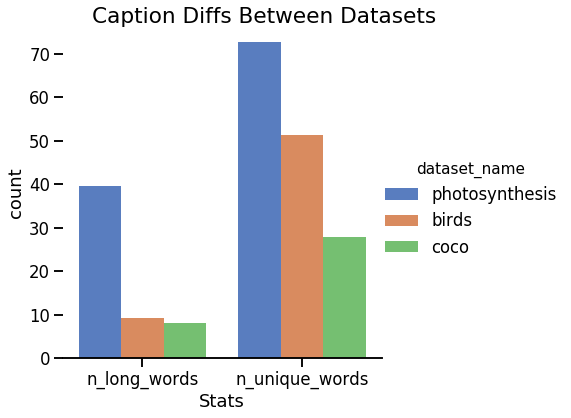

time: 466 ms


In [118]:
sns.set_context("talk")
f = sns.catplot(x="Stats", y="value", hue="dataset_name", data=graph_df,
                height=6, kind="bar", palette="muted", ci=None )
f.despine(left=True)
f.set_ylabels("count")
f.fig.suptitle("Caption Diffs Between Datasets")

#### birds

In [ ]:
graph_df['']

In [11]:
root_dir_nm = 'AttnGAN'
data_dir_nm = 'data'
metadata_dir_nm ='birds'

metadata_flpth = os.path.join("/home/ec2-user/environment/", root_dir_nm, data_dir_nm, metadata_dir_nm)
metadata_flpth

btxt_dir_flpth = os.path.join(metadata_flpth, 'text')
print(btxt_dir_flpth)
print(os.path.exists(btxt_dir_flpth))

/home/ec2-user/environment/AttnGAN/data/birds/text
True
time: 1.49 ms


In [12]:
# 1. Load text captions to corpus
birdsCrps = ptg.write.txt_to_corpus(btxt_dir_flpth, lang=en, txt_extention=".txt")
print(f"\nCorpus Info: {birdsCrps}")

DEBUG:root:Function: txt_to_corpus -- Loading Text from: /home/ec2-user/environment/AttnGAN/data/birds/text
DEBUG:root:Finished calculating CorpusStats
DEBUG:root:Function: txt_to_corpus -- Loaded 11788



Corpus Info: Corpus(11788 docs, 2124573 tokens)
time: 5min 47s


#### coco

In [13]:
root_dir_nm = 'AttnGAN'
data_dir_nm = 'data'
metadata_dir_nm ='coco'

metadata_flpth = os.path.join("/home/ec2-user/environment/", root_dir_nm, data_dir_nm, metadata_dir_nm)
metadata_flpth

coco_txt_dir_flpth = os.path.join(metadata_flpth, 'text')
print(btxt_dir_flpth)
print(os.path.exists(btxt_dir_flpth))

/home/ec2-user/environment/AttnGAN/data/birds/text
True
time: 1.41 ms


In [14]:
# 1. Load text captions to corpus
cocoCrps = ptg.write.txt_to_corpus(coco_txt_dir_flpth, lang=en, txt_extention=".txt")
print(f"\nCorpus Info: {cocoCrps}")

DEBUG:root:Function: txt_to_corpus -- Loading Text from: /home/ec2-user/environment/AttnGAN/data/coco/text
DEBUG:root:Finished calculating CorpusStats
DEBUG:root:Function: txt_to_corpus -- Loaded 40504



Corpus Info: Corpus(40504 docs, 2498514 tokens)
time: 9min 27s


In [15]:
cocoCrps.docstats_df.columns

Index(['filename', 'filepath', 'n_chars', 'n_long_words',
       'n_monosyllable_words', 'n_polysyllable_words', 'n_sents',
       'n_syllables', 'n_unique_words', 'n_words'],
      dtype='object')

time: 2.46 ms


/home/ec2-user/anaconda3/envs/py36-ml/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/ec2-user/anaconda3/envs/py36-ml/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


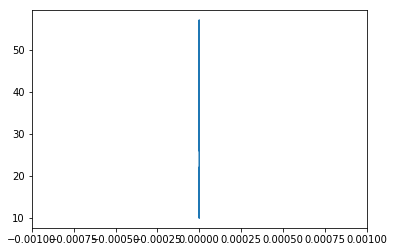

time: 223 ms


In [51]:
cocoCrps.docstats_df['n_unique_words'].plot()

In [47]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
output_notebook()

Loading BokehJS ...

time: 7.29 ms


In [48]:
p = figure()

source = ColumnDataSource(cocoCrps.docstats_df)

time: 264 ms


In [49]:
p.vbar(x='filename',
       top="n_words",
       source=source,
       width=10,
      fill_color="#b3de69")

GlyphRenderer(id='1999', ...)

time: 4.12 ms


In [50]:
output_file("lines.html")
show(p)

INFO:bokeh.io.state:Session output file 'lines.html' already exists, will be overwritten.


time: 501 ms


## Future Work

### Bounding boxes

In [ ]:
# In the rest of the tutorial, we assume that the `plt`
# is imported before every code snippet.
import matplotlib.pyplot as plt

from chainercv.datasets import voc_bbox_label_names
from chainercv.links import SSD300
from chainercv.utils import read_image
from chainercv.visualizations import vis_bbox

img_name = "photosynthesis_0.jpg"
img_flpth = os.path.join(image_data_flpth, img_name)

# Read an RGB image and return it in CHW format.
img = read_image(img_flpth)
model = SSD300(pretrained_model='voc0712')
bboxes, labels, scores = model.predict([img])
vis_bbox(img, bboxes[0], labels[0], scores[0],
         label_names=voc_bbox_label_names)
plt.show()

In [ ]:
os.path.join(metaFolder.metadata_flpth, 'train', "filenames.pickle")

In [ ]:
train, test = train_test_split(df["filename"], test_size=0.3)

In [ ]:
train.to_list()

In [ ]:
 os.path.basename(metaFolder.metadata_flpth)

In [ ]:
def sents_to_caption_lst(doc):
    """
    Split doc text by sentences and write to list
    """
    doc_captions_lst = [sent.text for sent in doc.sents]

    
    return doc_captions_lst


# 2. Modify training text data. i.e lowercase, ##maximize captions

# # 2.1  Read text data into a spacy corpus using textacy
crps = pmd.write.txt_to_corpus(text_training_data_flpth)

In [ ]:
doc_captions_lst = sents_to_caption_lst(doc)
doc_captions_lst

In [ ]:
doc._.meta[crps_file_tag]

In [ ]:
text = tst_doc.text

def write_doc_to_txt(doc, crps_file_tag="file_name"):

    # Write captions for google images
    f =  open(doc._.meta[crps_file_tag], 'w')
    print(f"Number of Sentences in doc: {doc._.n_sents}")
    
    # Parse Document into sentences
    
        # f.write(label+"\n" )
        f.write(caption+" " )

    f.close()
write_doc_to_txt()

In [ ]:
for doc in crps:
    

In [ ]:
data_dir_name

In [ ]:
data_path = os.path.join(os.path.expanduser("~"), 'imageGen/AttnGAN/data/')
print(os.path.exists(data_path))
data_path

In [ ]:

# # b. Maximize the number of captions per image
reshapedCaptions = idp.captions.ReshapeImageLabels(lbls_corpus)

In [ ]:
reshapedCaptions.captions_dict

In [ ]:
def df_to_corpus(df):
    # Load into textacy to delimit sentences
    img_labels = rsrc_df.to_dict(orient="records")
    records = textacy.io.split_records(img_labels, 'RESOURCE',itemwise=True)

    # Load english model
    en = en_core_web_sm.load()
    corpus = textacy.Corpus(lang=en, data=records)
    
    return corpus

In [ ]:
captionsCorpus = df_to_corpus(rsrc_df)
captionsCorpus

In [ ]:
for doc in captionsCorpus:
    print(doc._.preview)

### 

In [ ]:




# Write new image text 

### Create Labels for text to image model

In [ ]:
def handle_missing_directories(directory_flpth):
    # Handle missing Directory
    if not os.path.exists(directory_flpth):
        
        os.makedirs(directory_flpth)
        print("Made new directory: {}".format(directory_flpth))
        # print(os.path.join(dirname, flpth))
    else:
        pass
    
    return

# Create text file for each doc - Each Doc maps to an image

## TODO: incoroporate number of labals per line
def labels_to_imageTxt_files(rsrc_df, trainingData_term, trainigData_flpth='../data'):
    
    # Handle if a data directory for a term exists e.g. data/photosynthesis
    dirname = os.path.abspath('')
    termData_flpth = os.path.join(dirname, trainigData_flpth)
    handle_missing_directories(termData_flpth)
    
    
    ### Move resource df to textacy
   
    # Load into textacy to delimit sentences
    img_labels = rsrc_df.to_dict(orient="records")
    text_stream, metadata_stream = textacy.io.split_records(img_labels, 'RESOURCE')

    # Load english model
    en = en_core_web_sm.load()
    labels_corpus = textacy.Corpus(lang=en, texts=text_stream, metadatas=metadata_stream)
    
    caption_filename_path = os.path.join(trainigData_flpth, "captions.pickle")
    
    # Loop through corpus and write document to flpth (s3)
    ''' Each doc in a corpus equals and image'''
    for ix, doc in enumerate(labels_corpus):
        print("Number of Sentences: {}".format(doc.n_sents))
        
        # Paths to directories (Where to write the text files)
        filename = "{}_{}.txt".format(trainingData_term, ix)
        path_to_file = "{}/{}".format(trainigData_flpth, filename)
        
        # Write captions for google images
        f =  open(path_to_file, 'w')
        
        # Parse Document into sentences
        for sent in doc.sents:
            caption = textacy.preprocess.preprocess_text(sent.text,
                                               lowercase=True,
                                               no_punct=True
                                              )
            # f.write(label+"\n" )
            f.write(caption+" " )
            
        f.close()
        
    return ix + 1 # Count using 1 as start

# process labels for images


trainingData_term = 'photosynthesis'
txt_trainingData_flpth='{}/text'.format(termTxtToImage_flpth, 'text')

numText_files = labels_to_imageTxt_files(rsrc_df, trainingData_term, txt_trainingData_flpth)
numText_files

### Download Images from google 

In [ ]:

def download_images(term ,img_args):
    
    # Download Images 
    response = google_images_download.googleimagesdownload()
    img_paths = response.download(img_args)
    
    # Post Process google image results
    for idx, f in enumerate(img_paths[term]):
        
        # Open Google image resulst and conver to jpeg
        img = PIL.Image.open(f)
        img_filetype = img.format.lower()  # 'JPEG'
        
        rgb_img = img.convert('RGB')
        img.close()
        
        # Make new filenme to allign with text file name
        filename = "{}_{}.{}".format(trainingData_term, idx, 'jpg')
        newfilepath_f = os.path.join(os.path.dirname(f), filename)
        
        # Save and image
        rgb_img.save(newfilepath_f)
        os.remove(f)
    
    
    return response 

img_args = {"keywords":"sun",
             "format": "png",
              "limit": 20,
             "output_directory": 'data',
            "metadata": True,
            "image_directory": "photosynthesis/images",
            "no_download": False,
            "extract_metadata":True
            # "size":"icon"
           }

response = download_images(trainingData_term, img_args)

### 1. Inputs

In [ ]:
#import tigDataLoader.utiils as dataloader
import os
import json
import logging

In [ ]:
predictTerm = "photosynthesis"
dataTerm = "photosynthesis"

In [ ]:
# Base file io inputs
trainData_flpth = os.path.join('data', predictTerm)
text_flpth = os.path.join(trainData_flpth, 'text')
img_flpth =  os.path.join(trainData_flpth, 'images')

# Google imagae download metadata
imageLog_fir='logs'

In [ ]:
def transformText_to_captions(txtDoc, numCaptions_per_image=5, txtSplit_method='svo'):
    # Take textacy doc and converts to a list of captions for an image
    
    if txtSplit_method=='noun_chunks':
        split_list = list(textacy.extract.noun_chunks(txtDoc, drop_determiners=False, min_freq=1))
    if txtSplit_method=='svo':
        split_list = list(textacy.extract.subject_verb_object_triples(txtDoc))
    
    return split_list

### 3. Download images
- from google

In [ ]:
img_args = {"keywords": dataTerm,
             "format": "png",
              "limit": 100,
             "output_directory": 'data',
            "metadata": True,
            "image_directory": "{}/images/".format(predictTerm),
            "no_download": False,
            "extract_metadata":True,
            "type": "clipart"
           }
img_paths, response = dataloader.download_images(dataTerm, img_args)

In [ ]:
# Download text from 

In [ ]:
## load text into textacy
imgTxt_corpus = df_to_corpus()


In [ ]:
list(labels_corpus.docs[0].sents)

In [ ]:
import requests
r = requests.get("https://ssec.si.edu/stemvisions-blog/what-photosynthesis")

In [ ]:
r.content

In [ ]:
# Create Fake data
import shutil
import itertools

# Get a list of the original files f
txtDirFileNm_lst = glob.glob(text_flpth+"/**/*.txt", recursive=True)
imgDirFileNm_lst = glob.glob(img_flpth+"/**/*.jpg", recursive=True)

fileCombo_lst = list(itertools.product(txtDirFileNm_lst,imgDirFileNm_lst))

# for item in fileCombo_lst:
    
#     # Get text name
#     txtget_relfilename

# # # Create list paired tuple pairs
# # comboFlpth_lst = list(zip(txtDirFileNm_lst, imgDirFileNm_lst))
# # comboFlpth_lst

# # new_list = []
# # for k,v in comboFlpth_lst.iteritems():
# #     new_list.extend([x for x in combinations(v, 2)]) 
# # # for txtFile, imgFile in comboFlpth_dict:
# # #     # Make copies of files and rename
# # #     shutil.copyfile(txtFile, dst)
# # #     shutil.copyfile(imgFile, dst)

# # new_list



In [ ]:
import seaborn as sns
df = pd.read_csv("RUNS.csv")
df.shape

In [ ]:
sns.relplot(x="s_loss", y="embedding_dim", data=df);

# Notes

In [ ]:
greedy_algorithm(captions_df['n_chars'].tolist(), ideal_caption_length)

In [ ]:
greedy_algorithm(captions_df['n_chars'].tolist(), ideal_caption_length)

### Load text from s3 to df